<a href="https://colab.research.google.com/github/sindoll2/github-project/blob/main/LGBMRegressor(p).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
myfile = files.upload()

Saving membranedt3.csv to membranedt3.csv


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from lightgbm import LGBMRegressor
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import hstack
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from warnings import simplefilter


plt.style.use('fivethirtyeight')
simplefilter('ignore')

In [ ]:
df = pd.read_csv('membranedt3.csv', encoding='cp949', )

target_col = 'Membrane Flux '
seed = 12
print(df.shape)
df.head()

(692, 21)


Author  Year Mb AL Type Manufacture Mb Direction Flow Orientation  \
0  Arena et al.  2015        TFC       Oasys        AL-FS          counter   
1  Arena et al.  2015        TFC       Oasys        AL-FS          counter   
2  Arena et al.  2015        TFC       Oasys        AL-FS          counter   
3  Arena et al.  2015        TFC       Oasys        AL-DS          counter   
4  Arena et al.  2015        TFC       Oasys        AL-DS          counter   

  Feed Solution  FS Molarity  FS OP Draw Solution  ...  DS Osmotic pressure  \
0            DI          0.0    0.0          NaCl  ...                67.11   
1            DI          0.0    0.0          NaCl  ...                44.74   
2            DI          0.0    0.0          NaCl  ...                22.37   
3            DI          0.0    0.0          NaCl  ...                67.11   
4            DI          0.0    0.0          NaCl  ...                44.74   

   P Difference  FS Velocity  DS Velocity  FS Temperature  DS Temperature  \
0         67.11         25.0         25.0            20.0            20.0   
1         44.74         25.0         25.0            20.0            20.0   
2         22.37         25.0         25.0            20.0            20.0   
3         67.11         25.0         25.0            20.0            20.0   
4         44.74         25.0         25.0            20.0            20.0   

   Membrane Flux   Reverse Salt Flux     A     B  
0           23.84               0.11  0.36  0.07  
1           20.00               0.06  0.45  0.06  
2           14.52               0.04  0.65  0.09  
3           51.74               0.28  0.77  0.19  
4           43.20               0.21  0.97  0.21  

[5 rows x 21 columns]

In [ ]:
df['FS Velocity'].fillna(df['FS Velocity'].mean(), inplace=True)
df['DS Velocity'].fillna(df['DS Velocity'].mean(), inplace=True)
df = df.drop(df.columns[[18,20]], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Author               692 non-null    object 
 1   Year                 692 non-null    int64  
 2   Mb AL Type           692 non-null    object 
 3   Manufacture          692 non-null    object 
 4   Mb Direction         692 non-null    object 
 5   Flow Orientation     692 non-null    object 
 6   Feed Solution        692 non-null    object 
 7   FS Molarity          692 non-null    float64
 8   FS OP                692 non-null    float64
 9   Draw Solution        692 non-null    object 
 10  DS Molarity          692 non-null    float64
 11  DS Osmotic pressure  692 non-null    float64
 12  P Difference         692 non-null    float64
 13  FS Velocity          692 non-null    float64
 14  DS Velocity          692 non-null    float64
 15  FS Temperature       692 non-null    flo

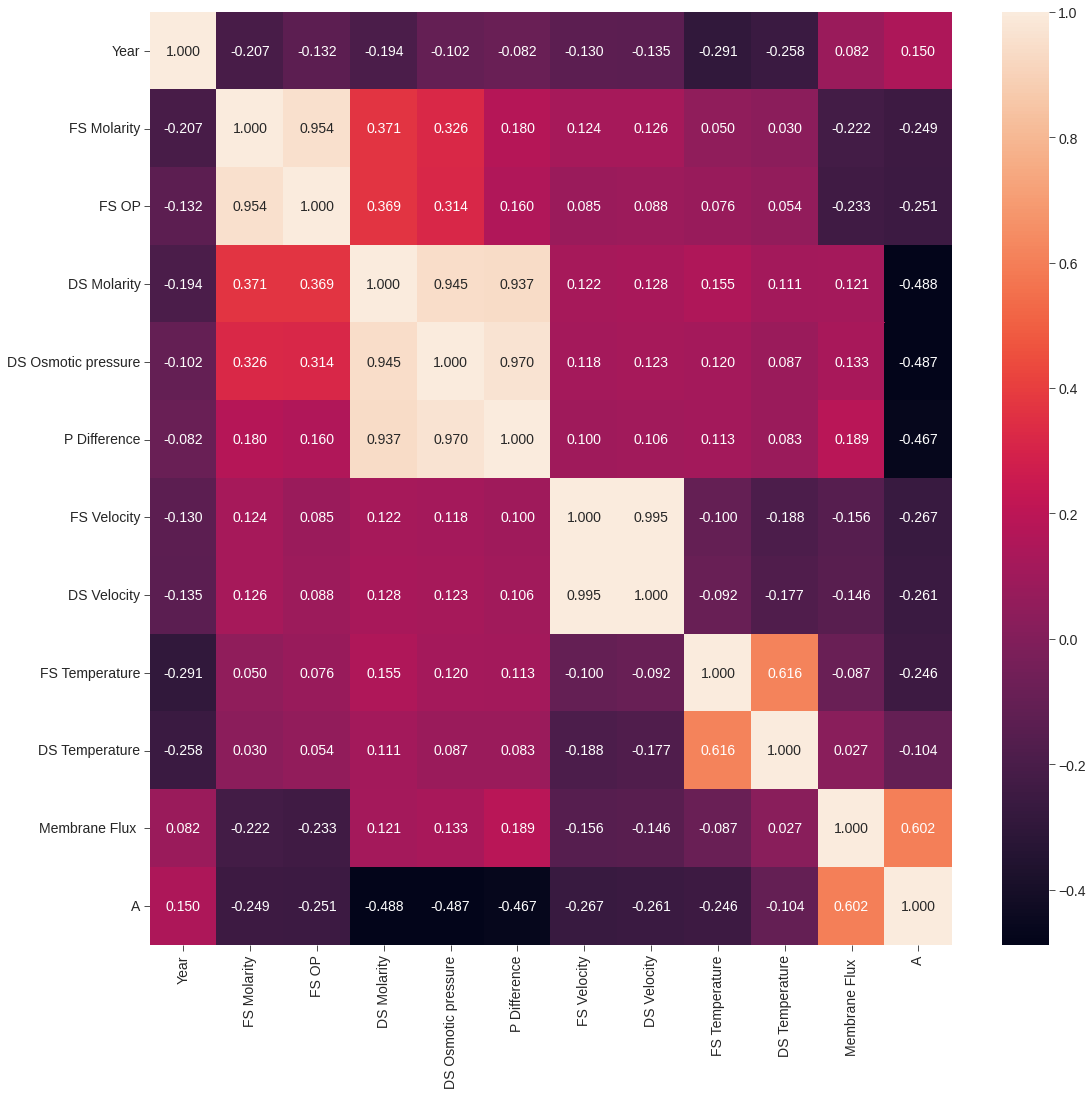

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize =(16,16))
sns.heatmap(df.corr(),annot=True, fmt ='.3f')

In [ ]:
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64]and x != target_col] 
cat_cols = ['Author', 'Mb AL Type', 'Manufacture', 'Mb Direction','Flow Orientation','Feed Solution','Draw Solution']
print(f'    numeric ({len(num_cols)}):\t{num_cols}')
print(f'categorical ({len(cat_cols)}):\t{cat_cols}')

    numeric (11):	['Year', 'FS Molarity', 'FS OP', 'DS Molarity', 'DS Osmotic pressure', 'P Difference', 'FS Velocity', 'DS Velocity', 'FS Temperature', 'DS Temperature', 'A']
categorical (7):	['Author', 'Mb AL Type', 'Manufacture', 'Mb Direction', 'Flow Orientation', 'Feed Solution', 'Draw Solution']


In [ ]:
df_ohe = pd.get_dummies(df, columns=cat_cols)

In [ ]:
X = df_ohe.drop(target_col, axis=1)
X.shape

(692, 91)

In [ ]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, df_ohe[target_col], test_size=0.2, random_state=10)
clf = LGBMRegressor(random_state=10)
clf.fit(X_trn, np.log1p(y_trn))
p = np.expm1(clf.predict(X_tst))
p_trn = np.expm1(clf.predict(X_trn))

if('Membrane Flux (LMH)' in df.keys()):
    print(df['Membrane Flux (LMH)'])
else:
    print('Membrane Flux (LMH) not found')

print('r2_score :', r2_score(y_tst, p))
print('r2_score :', r2_score(y_trn, p_trn))
print('MAE :', mean_absolute_error(y_tst, p))
print('MSE :', mean_squared_error(y_tst, p))
print('RMSE : ', mean_squared_error(y_tst, p, squared = False))
print('MAPE :', mean_absolute_percentage_error(y_tst, p))

Membrane Flux (LMH) not found
r2_score : 0.9606274805298475
r2_score : 0.9883801555250674
MAE : 1.1184201889068701
MSE : 4.854055202015951
RMSE :  2.2031920483734395
MAPE : 0.07578465676763126


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

KFold = KFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(clf, X, df[target_col], cv=KFold)

print('result :', results)
print('result mean :', results.mean())

result : [0.94237162 0.95686759 0.96374974 0.94590351 0.97300558]
result mean : 0.956379609410936


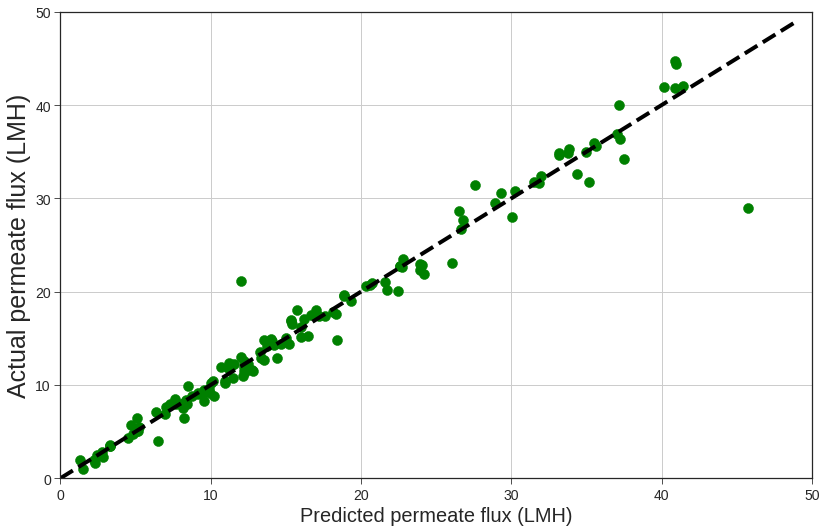

<Figure size 576x288 with 0 Axes>

In [ ]:
plt.style.use('seaborn-ticks')
rcParams['figure.figsize'] = (12, 8)
plt.scatter(p, y_tst, s=100, c='g')
plt.xlabel("Predicted permeate flux (LMH)", size=20)
plt.ylabel("Actual permeate flux (LMH)", size=25)
plt.grid(True)
plt.axis([0,50,0,50])

x = np.arange(0,50, 1)
y = x 
plt.plot(x,y, 'k', linestyle='--')
plt.figure(figsize=(8,4))
plt.show()

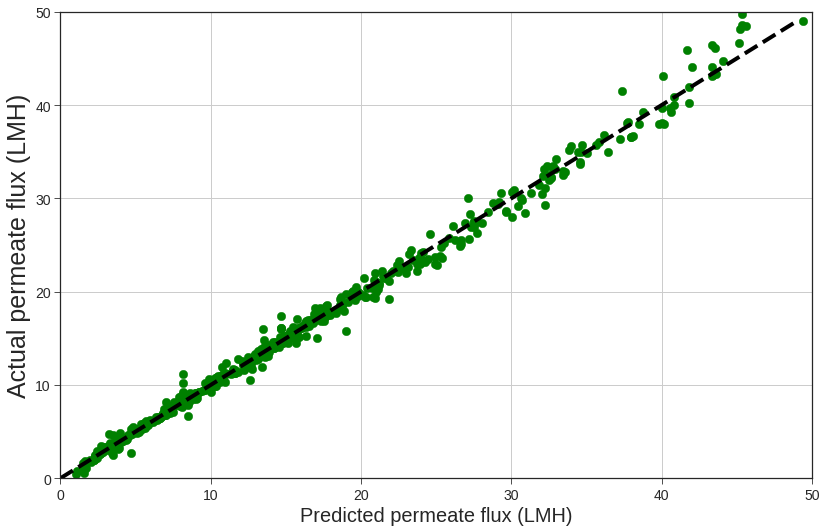

<Figure size 576x288 with 0 Axes>

In [ ]:
plt.scatter(p_trn, y_trn, s=70, c='g')
plt.xlabel("Predicted permeate flux (LMH)", size=20)
plt.ylabel("Actual permeate flux (LMH)", size=25)
plt.grid(True)
plt.axis([0,50,0,50])

x = np.arange(0, 50, 1)
y = x 
plt.plot(x,y, 'k', linestyle='--')
plt.figure(figsize=(8,4))
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

params = { 'min_samples_split':[1,2,3,4,5],
          'max_depth' : [1, 2, 3, 4, 5],
          'n_estimators' : [100, 1000],
          'gamma' : [0, 1],
          'learning rate' : [0.01, 0.001],
          'reg_alpha' : np.arange(0, 1, 0.2),
         'reg_lambda' : np.arange(0, 1, 0.2)
          }

gs = GridSearchCV(LGBMRegressor(random_state=10), params, n_jobs=-1)
gs.fit(X_trn, y_trn)

clf = gs.best_estimator_
print(clf.score(X_trn, y_trn))
print(gs.best_params_)
#print(gs.cv_results_['mean_test_score'])
# 1시간?
gs_df = pd.DataFrame(gs.cv_results_)
gs_df.loc[:, ['mean_test_score', "params"]]

best_model = gs.best_estimator_
best_model

best_score = gs.best_score_
print('GridSearchCV 최고 정확도 :', best_score)

0.9967067169426269
{'gamma': 0, 'learning rate': 0.01, 'max_depth': 3, 'min_samples_split': 1, 'n_estimators': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
GridSearchCV 최고 정확도 : 0.9676598523917888


In [ ]:
gs_df = pd.DataFrame(gs.cv_results_)
gs_df.loc[:, ['mean_test_score', "params"]]

mean_test_score                                             params
0            0.863585  {'gamma': 0, 'learning rate': 0.01, 'max_depth...
1            0.864055  {'gamma': 0, 'learning rate': 0.01, 'max_depth...
2            0.863997  {'gamma': 0, 'learning rate': 0.01, 'max_depth...
3            0.863872  {'gamma': 0, 'learning rate': 0.01, 'max_depth...
4            0.863959  {'gamma': 0, 'learning rate': 0.01, 'max_depth...
...               ...                                                ...
4995         0.961505  {'gamma': 1, 'learning rate': 0.001, 'max_dept...
4996         0.961845  {'gamma': 1, 'learning rate': 0.001, 'max_dept...
4997         0.961346  {'gamma': 1, 'learning rate': 0.001, 'max_dept...
4998         0.961678  {'gamma': 1, 'learning rate': 0.001, 'max_dept...
4999         0.961557  {'gamma': 1, 'learning rate': 0.001, 'max_dept...

[5000 rows x 2 columns]

In [ ]:
best_model = gs.best_estimator_
best_model

best_score = gs.best_score_
print('GridSearchCV 최고 정확도 :', best_score)

NameError: ignored

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.9 MB/s 


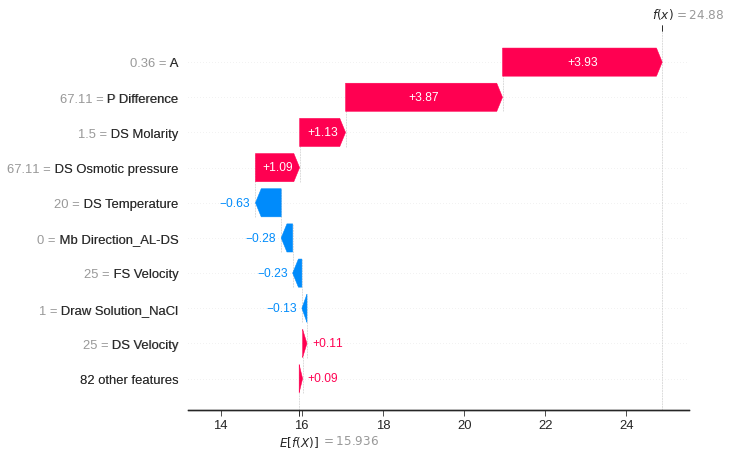

In [ ]:
import shap

explainer = shap.Explainer(clf)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

In [ ]:
# visualize all the training set predictions
shap.initjs()
shap.plots.force(shap_values)

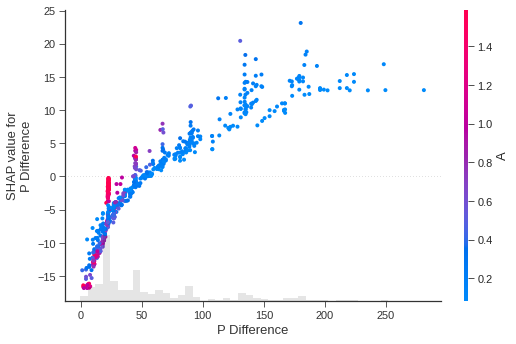

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.initjs()
shap.plots.scatter(shap_values[:,"P Difference"], color=shap_values)

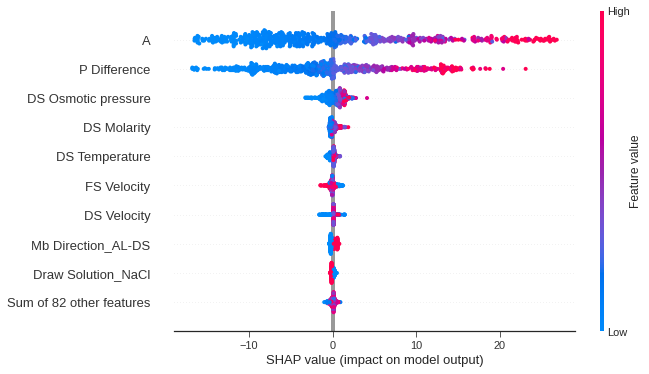

In [ ]:
# summarize the effects of all the features
shap.initjs()
shap.plots.beeswarm(shap_values)

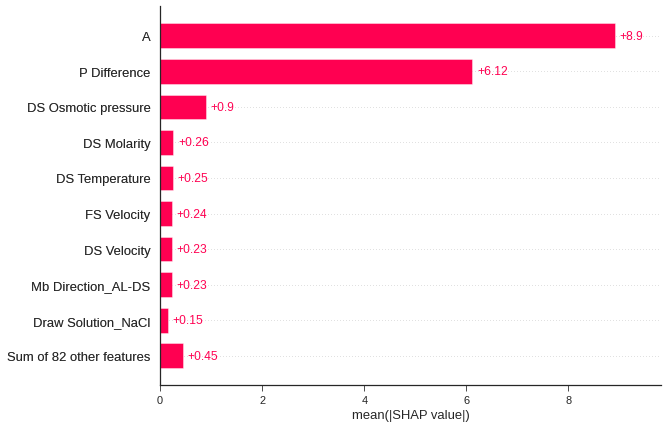

In [ ]:
shap.initjs()
shap.plots.bar(shap_values)